<a href="https://colab.research.google.com/github/konkuk-gaegul/3rd-Team-Project/blob/main/%EC%A0%84%EC%A0%9C%EC%A1%B0%EA%B1%B4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 전제조건의 필요성
- 정상/비만 분류 모델은 사람 이미지를 입력해도 비만/정상 분류를 진행한다.
- 그래도 사람과 고양이 정도는 걸러내자! 라는 의의에서 시작되었다.
- 고양이, 개, 사람 3개 클래스로 분류
    - 각 4천, 7천, 3천 장으로 학습

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable

import torchvision
from torchvision import datasets, models, transforms

import numpy as np
import time

import copy
import os, shutil
import matplotlib as plt

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # device 객체

In [ ]:
base_dir = '/home/tutor/안재형/dog_pic/사전조건'

nor_path = os.path.join(base_dir, '정상')
nor_list = os.listdir(nor_path)

fat_path = os.path.join(base_dir, '비만')
fat_list = os.listdir(fat_path)

target_folder = os.path.join(base_dir, 'dog')

# copy normal imgs to dog folder
for i in range(len(nor_list)):
    src_path = os.path.join(nor_path, nor_list[i])
    dst_path = os.path.join(target_folder, f'dogN_{i}')
    shutil.copyfile( src_path, dst_path)
    
# copy normal imgs to dog folder
for i in range(len(fat_list)):
    src_path = os.path.join(fat_path, fat_list[i])
    dst_path = os.path.join(target_folder, f'dogF_{i}')
    shutil.copyfile( src_path, dst_path)

In [ ]:
print(len(os.listdir('/home/tutor/안재형/dog_pic/사전조건/set_1/dog')))
print(len(os.listdir('/home/tutor/안재형/dog_pic/사전조건/set_1/cat')))
print(len(os.listdir('/home/tutor/안재형/dog_pic/사전조건/set_1/human')))

# train, test split 함수

In [ ]:
for i in range(1, 2):
    base_dir = '/home/tutor/안재형/dog_pic/사전조건'
    base_folder = os.path.join(base_dir, f'set_{i}')
    # # 훈련셋, 검증셋, 테스트셋을 미리 분할하기 위한 폴더 경로
    train_path = os.path.join(base_folder, 'train')
    os.mkdir( train_path)

    test_path = os.path.join(base_folder, 'test')
    os.mkdir( test_path)

    
    # # train 개 폴더
    train_dog_path = os.path.join(train_path, 'dog')
    os.mkdir( train_dog_path)

    # # train 고양이 폴더
    train_cat_path = os.path.join(train_path, 'cat')
    os.mkdir( train_cat_path)
    
    # # train 사람 폴더
    train_human_path = os.path.join(train_path, 'human')
    os.mkdir( train_human_path)

    
    # # test 개 폴더
    test_dog_path = os.path.join(test_path, 'dog')
    os.mkdir( test_dog_path)

    # # test 고양이 폴더
    test_cat_path = os.path.join(test_path, 'cat')
    os.mkdir( test_cat_path)
    
    # # train 사람 폴더
    test_human_path = os.path.join(test_path, 'human')
    os.mkdir( test_human_path)
    
    
    dog_path = os.path.join(base_dir, 'dog')
    cat_path = os.path.join(base_dir, 'cat')
    human_path = os.path.join(base_dir, 'human')

    dog_list = os.listdir(dog_path)
    cat_list = os.listdir(cat_path)
    human_list = os.listdir(human_path)
    
    print(f'사전조건 set_{i}')
    print(len(dog_list))
    print(len(cat_list))
    print(len(human_list))
    print('---------')
    
    
    # train : 75%, test : 25%
    # 개 이미지 복사
    for i in range(len(dog_list)):
        src_path = os.path.join(dog_path, dog_list[i])

        if i < len(dog_list)*0.75:
            dst_path = os.path.join(train_dog_path, f'dog_{i}.jpg')
            shutil.copyfile( src_path, dst_path )
        else :
            dst_path = os.path.join(test_dog_path, f'dog_{i}.jpg')
            shutil.copyfile( src_path, dst_path )

    # 고양이 이미지 복사
    for i in range(len(cat_list)):
        src_path = os.path.join(cat_path, cat_list[i])

        if i < len(cat_list)*0.75:
            dst_path = os.path.join(train_cat_path, f'cat_{i}.jpg')
            shutil.copyfile( src_path, dst_path )
        else :
            dst_path = os.path.join(test_cat_path, f'cat_{i}.jpg')
            shutil.copyfile( src_path, dst_path )
            
    # 사람 이미지 복사
    for i in range(len(human_list)):
        src_path = os.path.join(human_path, human_list[i])

        if i < len(human_list)*0.75:
            dst_path = os.path.join(train_human_path, f'human_{i}.jpg')
            shutil.copyfile( src_path, dst_path )
        else :
            dst_path = os.path.join(test_human_path, f'human_{i}.jpg')
            shutil.copyfile( src_path, dst_path )

# pytorch transfer learning
- 파이토치 전이학습 함수

In [ ]:
# i : 몇 번째 세트, data_dir = '/home/tutor/안재형/dog_pic/사전조건',
# batch : batch_size, epoch : num_epoch
def pytorch_TL(i, data_dir, batch, epoch):
    
    transforms_train = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
        transforms.RandomHorizontalFlip(), # 데이터 증진(augmentation)
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # 정규화(normalization)
        ])

    transforms_test = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
    
    data_folder = os.path.join(data_dir, f'set_{i}')
    train_datasets = datasets.ImageFolder(os.path.join(data_folder, 'train'), transforms_train)
    test_datasets = datasets.ImageFolder(os.path.join(data_folder, 'test'), transforms_test)

    train_dataloader = torch.utils.data.DataLoader(train_datasets, batch_size=batch , shuffle=True, num_workers=2)
    test_dataloader  = torch.utils.data.DataLoader(test_datasets , batch_size=batch , shuffle=True, num_workers=2)

    print('학습 데이터셋 크기:', len(train_datasets))
    print('테스트 데이터셋 크기:', len(test_datasets))

    class_names = train_datasets.classes
    print('클래스:', class_names)
    
    #--------------------------------------------#
    model = models.resnet34(pretrained=True)
    num_features = model.fc.in_features
    # 전이 학습(transfer learning): 모델의 출력 뉴런 수를 3개로 교체하여 마지막 레이어 다시 학습
    model.fc = nn.Linear(num_features, 3)
    model = model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    #--------------------------------------------#
    
    print(f'-------------현재 set_{i} batch_size : {batch}-------------')
    num_epochs = epoch
    model.train()
    start_time = time.time()

    # 전체 반복(epoch) 수 만큼 반복하며
    for epoch in range(num_epochs):
        running_loss = 0.
        running_corrects = 0

        # 배치 단위로 학습 데이터 불러오기
        for inputs, labels in train_dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # 모델에 입력(forward)하고 결과 계산
            optimizer.zero_grad()
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            # 역전파를 통해 기울기(gradient) 계산 및 학습 진행
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(train_datasets)
        epoch_acc = running_corrects / len(train_datasets) * 100.

        # 학습 과정 중에 결과 출력
        print('#{} Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch, epoch_loss, epoch_acc, time.time() - start_time))

    #--------------------------------------------#
    model.eval()
    start_time = time.time()

    with torch.no_grad():
        running_loss = 0.
        running_corrects = 0

        for inputs, labels in test_dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

            # 한 배치의 첫 번째 이미지에 대하여 결과 시각화
            print(f'[예측 결과: {class_names[preds[0]]}] (실제 정답: {class_names[labels.data[0]]})')

        epoch_loss = running_loss / len(test_datasets)
        epoch_acc = running_corrects / len(test_datasets) * 100.
        print('[Test Phase] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch_loss, epoch_acc, time.time() - start_time))
        
        Loss_Acc = [i, epoch_loss, epoch_acc]
        torch.save(model, f'/home/tutor/안재형/dog_pic/사전조건/precondition_set{i}_B{batch}_E{epoch}.pth')

In [ ]:
# i : 몇 번째 세트, data_dir = '/home/tutor/안재형/dog_pic/사전조건',
# batch : batch_size, epoch : num_epoch
# pytorch_TL(i, data_dir, batch, epoch):

i = 1
data_dir = '/home/tutor/안재형/dog_pic/사전조건'
batch = 20
epoch = 50

pytorch_TL(1, data_dir, batch, epoch)

학습 데이터셋 크기: 10479
테스트 데이터셋 크기: 3492
클래스: ['cat', 'dog', 'human']
-------------현재 set_1 batch_size : 20-------------


/home/ubuntu/anaconda3/envs/tensorflow_tutor/lib/python3.7/site-packages/PIL/Image.py:946: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


#0 Loss: 0.0924 Acc: 96.6600% Time: 108.1543s


/home/ubuntu/anaconda3/envs/tensorflow_tutor/lib/python3.7/site-packages/PIL/Image.py:946: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


#1 Loss: 0.0270 Acc: 99.1602% Time: 192.9948s


/home/ubuntu/anaconda3/envs/tensorflow_tutor/lib/python3.7/site-packages/PIL/Image.py:946: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


#2 Loss: 0.0225 Acc: 99.3129% Time: 278.3328s


/home/ubuntu/anaconda3/envs/tensorflow_tutor/lib/python3.7/site-packages/PIL/Image.py:946: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


#3 Loss: 0.0132 Acc: 99.5992% Time: 363.5292s


/home/ubuntu/anaconda3/envs/tensorflow_tutor/lib/python3.7/site-packages/PIL/Image.py:946: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


#4 Loss: 0.0115 Acc: 99.6374% Time: 449.4539s


/home/ubuntu/anaconda3/envs/tensorflow_tutor/lib/python3.7/site-packages/PIL/Image.py:946: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


#5 Loss: 0.0061 Acc: 99.8378% Time: 541.3629s


/home/ubuntu/anaconda3/envs/tensorflow_tutor/lib/python3.7/site-packages/PIL/Image.py:946: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


#6 Loss: 0.0038 Acc: 99.9332% Time: 649.6506s


/home/ubuntu/anaconda3/envs/tensorflow_tutor/lib/python3.7/site-packages/PIL/Image.py:946: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


#7 Loss: 0.0036 Acc: 99.9141% Time: 749.3632s


/home/ubuntu/anaconda3/envs/tensorflow_tutor/lib/python3.7/site-packages/PIL/Image.py:946: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


#8 Loss: 0.0038 Acc: 99.8759% Time: 834.4993s


/home/ubuntu/anaconda3/envs/tensorflow_tutor/lib/python3.7/site-packages/PIL/Image.py:946: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


#9 Loss: 0.0036 Acc: 99.8950% Time: 918.4801s


/home/ubuntu/anaconda3/envs/tensorflow_tutor/lib/python3.7/site-packages/PIL/Image.py:946: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


#10 Loss: 0.0046 Acc: 99.8664% Time: 1002.8268s


/home/ubuntu/anaconda3/envs/tensorflow_tutor/lib/python3.7/site-packages/PIL/Image.py:946: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


#11 Loss: 0.0022 Acc: 99.9237% Time: 1088.5426s


/home/ubuntu/anaconda3/envs/tensorflow_tutor/lib/python3.7/site-packages/PIL/Image.py:946: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


#12 Loss: 0.0021 Acc: 99.9523% Time: 1172.8665s


/home/ubuntu/anaconda3/envs/tensorflow_tutor/lib/python3.7/site-packages/PIL/Image.py:946: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


#13 Loss: 0.0040 Acc: 99.8855% Time: 1257.6618s


/home/ubuntu/anaconda3/envs/tensorflow_tutor/lib/python3.7/site-packages/PIL/Image.py:946: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


#14 Loss: 0.0040 Acc: 99.8378% Time: 1343.5160s


/home/ubuntu/anaconda3/envs/tensorflow_tutor/lib/python3.7/site-packages/PIL/Image.py:946: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


#15 Loss: 0.0020 Acc: 99.9427% Time: 1443.8200s


/home/ubuntu/anaconda3/envs/tensorflow_tutor/lib/python3.7/site-packages/PIL/Image.py:946: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


#16 Loss: 0.0017 Acc: 99.9714% Time: 1553.5603s


/home/ubuntu/anaconda3/envs/tensorflow_tutor/lib/python3.7/site-packages/PIL/Image.py:946: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


#17 Loss: 0.0027 Acc: 99.9332% Time: 1647.0515s


/home/ubuntu/anaconda3/envs/tensorflow_tutor/lib/python3.7/site-packages/PIL/Image.py:946: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


#18 Loss: 0.0028 Acc: 99.9046% Time: 1734.4724s


/home/ubuntu/anaconda3/envs/tensorflow_tutor/lib/python3.7/site-packages/PIL/Image.py:946: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


#19 Loss: 0.0012 Acc: 99.9904% Time: 1823.1186s


/home/ubuntu/anaconda3/envs/tensorflow_tutor/lib/python3.7/site-packages/PIL/Image.py:946: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


#20 Loss: 0.0012 Acc: 99.9618% Time: 1932.3950s


/home/ubuntu/anaconda3/envs/tensorflow_tutor/lib/python3.7/site-packages/PIL/Image.py:946: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


#21 Loss: 0.0014 Acc: 99.9523% Time: 2034.6922s


/home/ubuntu/anaconda3/envs/tensorflow_tutor/lib/python3.7/site-packages/PIL/Image.py:946: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


#22 Loss: 0.0006 Acc: 100.0000% Time: 2120.7216s


/home/ubuntu/anaconda3/envs/tensorflow_tutor/lib/python3.7/site-packages/PIL/Image.py:946: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


#23 Loss: 0.0012 Acc: 99.9618% Time: 2206.4754s


/home/ubuntu/anaconda3/envs/tensorflow_tutor/lib/python3.7/site-packages/PIL/Image.py:946: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


#24 Loss: 0.0010 Acc: 99.9809% Time: 2292.4562s


/home/ubuntu/anaconda3/envs/tensorflow_tutor/lib/python3.7/site-packages/PIL/Image.py:946: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


#25 Loss: 0.0006 Acc: 99.9904% Time: 2376.9954s


/home/ubuntu/anaconda3/envs/tensorflow_tutor/lib/python3.7/site-packages/PIL/Image.py:946: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


#26 Loss: 0.0003 Acc: 100.0000% Time: 2462.3166s


/home/ubuntu/anaconda3/envs/tensorflow_tutor/lib/python3.7/site-packages/PIL/Image.py:946: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


#27 Loss: 0.0005 Acc: 99.9904% Time: 2548.1407s


/home/ubuntu/anaconda3/envs/tensorflow_tutor/lib/python3.7/site-packages/PIL/Image.py:946: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


#28 Loss: 0.0013 Acc: 99.9714% Time: 2632.7831s


/home/ubuntu/anaconda3/envs/tensorflow_tutor/lib/python3.7/site-packages/PIL/Image.py:946: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


#29 Loss: 0.0005 Acc: 99.9904% Time: 2721.3653s


/home/ubuntu/anaconda3/envs/tensorflow_tutor/lib/python3.7/site-packages/PIL/Image.py:946: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


#30 Loss: 0.0005 Acc: 100.0000% Time: 2831.1644s


/home/ubuntu/anaconda3/envs/tensorflow_tutor/lib/python3.7/site-packages/PIL/Image.py:946: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


#31 Loss: 0.0004 Acc: 100.0000% Time: 2938.3369s


/home/ubuntu/anaconda3/envs/tensorflow_tutor/lib/python3.7/site-packages/PIL/Image.py:946: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


#32 Loss: 0.0022 Acc: 99.9523% Time: 3024.7090s


/home/ubuntu/anaconda3/envs/tensorflow_tutor/lib/python3.7/site-packages/PIL/Image.py:946: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


#33 Loss: 0.0017 Acc: 99.9523% Time: 3110.3956s


/home/ubuntu/anaconda3/envs/tensorflow_tutor/lib/python3.7/site-packages/PIL/Image.py:946: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


#34 Loss: 0.0007 Acc: 99.9714% Time: 3195.5786s


/home/ubuntu/anaconda3/envs/tensorflow_tutor/lib/python3.7/site-packages/PIL/Image.py:946: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


#35 Loss: 0.0007 Acc: 100.0000% Time: 3280.7160s


/home/ubuntu/anaconda3/envs/tensorflow_tutor/lib/python3.7/site-packages/PIL/Image.py:946: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


#36 Loss: 0.0004 Acc: 100.0000% Time: 3365.8683s


/home/ubuntu/anaconda3/envs/tensorflow_tutor/lib/python3.7/site-packages/PIL/Image.py:946: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


#37 Loss: 0.0006 Acc: 99.9904% Time: 3450.4611s


/home/ubuntu/anaconda3/envs/tensorflow_tutor/lib/python3.7/site-packages/PIL/Image.py:946: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


#38 Loss: 0.0006 Acc: 99.9904% Time: 3535.5491s


/home/ubuntu/anaconda3/envs/tensorflow_tutor/lib/python3.7/site-packages/PIL/Image.py:946: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


#39 Loss: 0.0005 Acc: 99.9904% Time: 3620.0168s


/home/ubuntu/anaconda3/envs/tensorflow_tutor/lib/python3.7/site-packages/PIL/Image.py:946: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


#40 Loss: 0.0003 Acc: 100.0000% Time: 3705.4306s


/home/ubuntu/anaconda3/envs/tensorflow_tutor/lib/python3.7/site-packages/PIL/Image.py:946: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


#41 Loss: 0.0002 Acc: 100.0000% Time: 3789.7457s


/home/ubuntu/anaconda3/envs/tensorflow_tutor/lib/python3.7/site-packages/PIL/Image.py:946: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


#42 Loss: 0.0004 Acc: 99.9904% Time: 3874.2121s


/home/ubuntu/anaconda3/envs/tensorflow_tutor/lib/python3.7/site-packages/PIL/Image.py:946: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


#43 Loss: 0.0006 Acc: 99.9904% Time: 3960.3251s


/home/ubuntu/anaconda3/envs/tensorflow_tutor/lib/python3.7/site-packages/PIL/Image.py:946: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


#44 Loss: 0.0002 Acc: 100.0000% Time: 4044.2886s


/home/ubuntu/anaconda3/envs/tensorflow_tutor/lib/python3.7/site-packages/PIL/Image.py:946: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


#45 Loss: 0.0004 Acc: 99.9904% Time: 4127.9063s


/home/ubuntu/anaconda3/envs/tensorflow_tutor/lib/python3.7/site-packages/PIL/Image.py:946: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


#46 Loss: 0.0002 Acc: 99.9904% Time: 4213.9408s


/home/ubuntu/anaconda3/envs/tensorflow_tutor/lib/python3.7/site-packages/PIL/Image.py:946: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


#47 Loss: 0.0004 Acc: 99.9904% Time: 4298.2669s


/home/ubuntu/anaconda3/envs/tensorflow_tutor/lib/python3.7/site-packages/PIL/Image.py:946: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


#48 Loss: 0.0005 Acc: 99.9809% Time: 4384.0267s


/home/ubuntu/anaconda3/envs/tensorflow_tutor/lib/python3.7/site-packages/PIL/Image.py:946: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


#49 Loss: 0.0002 Acc: 100.0000% Time: 4468.6003s
[예측 결과: dog] (실제 정답: dog)
[예측 결과: human] (실제 정답: human)
[예측 결과: dog] (실제 정답: dog)
[예측 결과: dog] (실제 정답: dog)
[예측 결과: human] (실제 정답: human)
[예측 결과: dog] (실제 정답: dog)
[예측 결과: cat] (실제 정답: cat)
[예측 결과: dog] (실제 정답: dog)
[예측 결과: dog] (실제 정답: dog)
[예측 결과: dog] (실제 정답: dog)
[예측 결과: cat] (실제 정답: cat)
[예측 결과: human] (실제 정답: human)
[예측 결과: human] (실제 정답: human)
[예측 결과: dog] (실제 정답: dog)
[예측 결과: cat] (실제 정답: cat)
[예측 결과: dog] (실제 정답: dog)
[예측 결과: dog] (실제 정답: dog)
[예측 결과: human] (실제 정답: human)
[예측 결과: dog] (실제 정답: dog)
[예측 결과: dog] (실제 정답: dog)
[예측 결과: dog] (실제 정답: dog)
[예측 결과: cat] (실제 정답: cat)
[예측 결과: cat] (실제 정답: cat)
[예측 결과: human] (실제 정답: human)
[예측 결과: dog] (실제 정답: dog)
[예측 결과: cat] (실제 정답: cat)
[예측 결과: dog] (실제 정답: dog)
[예측 결과: human] (실제 정답: human)
[예측 결과: human] (실제 정답: human)
[예측 결과: dog] (실제 정답: dog)
[예측 결과: dog] (실제 정답: dog)
[예측 결과: dog] (실제 정답: dog)
[예측 결과: dog] (실제 정답: dog)
[예측 결과: human] (실제 정답: human)
[예측 결과: dog] (실제 정답: dog)
[예측 결

## 학습 후기
- Test 자료
    - Loss = 0.0205, Acc = 99.54%

# 분류 TEST

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchvision
from torchvision import datasets, models, transforms

import os, cv2
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # device 객체

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

In [ ]:
%cd /home/tutor/안재형/saved_files/사전조건

/home/tutor/안재형/saved_files/사전조건


In [ ]:
# 이 결과가 파일명입니다.
!dir

precondition_set1_B20_E49.pth


In [ ]:
model = torch.load('/home/tutor/안재형/saved_files/사전조건/precondition_set1_B20_E49.pth')

In [ ]:
import io
from flask_ngrok import run_with_ngrok
from flask import Flask, jsonify, request

transforms_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
data_dir = '/home/tutor/안재형/dog_pic'

class_names = ['cat', 'dog', 'human']

def imshow(input, title):
    # torch.Tensor를 numpy 객체로 변환
    input = input.numpy().transpose((1, 2, 0))
    # 이미지 정규화 해제하기
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    input = std * input + mean
    input = np.clip(input, 0, 1)
    # 이미지 출력
    plt.imshow(input)
    plt.title(title)
    plt.show()

# 이미지를 읽어 결과를 반환하는 함수
def get_prediction(image_bytes):
    image = Image.open(io.BytesIO(image_bytes))
    image = transforms_test(image).unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(image)
        _, preds = torch.max(outputs, 1)
        imshow(image.cpu().data[0], title='예측 결과: ' + class_names[preds[0]])

    return class_names[preds[0]]

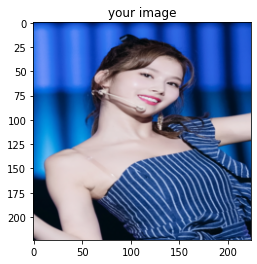

당신의 이미지는 human 입니다! 성견 이미지를 업로드하세요


In [ ]:
from PIL import Image
image = Image.open('/home/tutor/안재형/dog_pic/test_set/human/test_human.jpg')
image = transforms_test(image).unsqueeze(0).to(device)

with torch.no_grad():
    outputs = model(image)
    _, preds = torch.max(outputs, 1)
    imshow(image.cpu().data[0], title = 'your image')
    print(f'당신의 이미지는 {class_names[preds[0]]} 입니다! 성견 이미지를 업로드하세요')

In [ ]:
# Tensor of shape 3, with confidence scores over Imagenet's 3 classes
print(outputs[0])

# The output has unnormalized scores. To get probabilities, you can run a softmax on it.
probabilities = torch.nn.functional.softmax(outputs[0], dim=0)
print(probabilities)

tensor([-4.8655, -4.8662, 10.4668], device='cuda:0')
tensor([2.1940e-07, 2.1925e-07, 1.0000e+00], device='cuda:0')


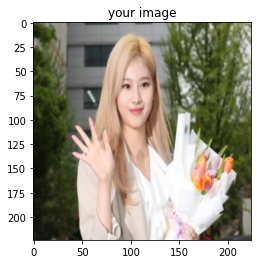

당신의 이미지는 human 입니다! 성견 이미지를 업로드하세요


In [ ]:
from PIL import Image
image = Image.open('/home/tutor/안재형/dog_pic/test_set/human/test_human(2).jpg')
image = transforms_test(image).unsqueeze(0).to(device)

with torch.no_grad():
    outputs = model(image)
    _, preds = torch.max(outputs, 1)
    imshow(image.cpu().data[0], title = 'your image')
    print(f'당신의 이미지는 {class_names[preds[0]]} 입니다! 성견 이미지를 업로드하세요')

In [ ]:
# Tensor of shape 3, with confidence scores over Imagenet's 3 classes
print(outputs[0])

# The output has unnormalized scores. To get probabilities, you can run a softmax on it.
probabilities = torch.nn.functional.softmax(outputs[0], dim=0)
print(probabilities)

tensor([-4.2724, -3.9246,  7.8685], device='cuda:0')
tensor([5.3369e-06, 7.5568e-06, 9.9999e-01], device='cuda:0')


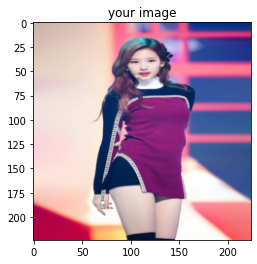

당신의 이미지는 human 입니다! 성견 이미지를 업로드하세요


In [ ]:
from PIL import Image
image = Image.open('/home/tutor/안재형/dog_pic/test_set/human/test_human(3).jpg')
image = transforms_test(image).unsqueeze(0).to(device)

with torch.no_grad():
    outputs = model(image)
    _, preds = torch.max(outputs, 1)
    imshow(image.cpu().data[0], title = 'your image')
    print(f'당신의 이미지는 {class_names[preds[0]]} 입니다! 성견 이미지를 업로드하세요')

In [ ]:
# Tensor of shape 3, with confidence scores over Imagenet's 3 classes
print(outputs[0])

# The output has unnormalized scores. To get probabilities, you can run a softmax on it.
probabilities = torch.nn.functional.softmax(outputs[0], dim=0)
print(probabilities)

tensor([-6.9339, -3.8863, 12.3171], device='cuda:0')
tensor([4.3592e-09, 9.1821e-08, 1.0000e+00], device='cuda:0')


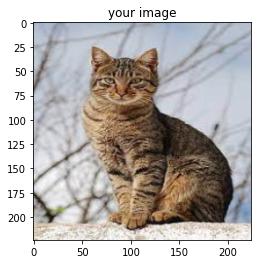

당신의 이미지는 cat 입니다! 성견 이미지를 업로드하세요


In [ ]:
from PIL import Image
image = Image.open('/home/tutor/안재형/dog_pic/test_set/cat/test_cat.jpg')
image = transforms_test(image).unsqueeze(0).to(device)

with torch.no_grad():
    outputs = model(image)
    _, preds = torch.max(outputs, 1)
    imshow(image.cpu().data[0], title = 'your image')
    print(f'당신의 이미지는 {class_names[preds[0]]} 입니다! 성견 이미지를 업로드하세요')

In [ ]:
# Tensor of shape 3, with confidence scores over Imagenet's 3 classes
print(outputs[0])

# The output has unnormalized scores. To get probabilities, you can run a softmax on it.
probabilities = torch.nn.functional.softmax(outputs[0], dim=0)
print(probabilities)

tensor([ 5.6849, -2.3044, -3.7751], device='cuda:0')
tensor([9.9958e-01, 3.3891e-04, 7.7872e-05], device='cuda:0')


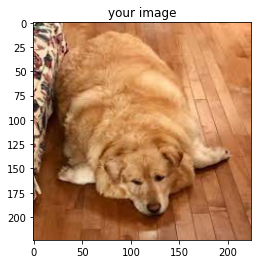

당신의 이미지는 dog 입니다! 성견 이미지를 업로드하세요


In [ ]:
from PIL import Image
image = Image.open('/home/tutor/안재형/dog_pic/test_set/dog/test_dog.jpg')
image = transforms_test(image).unsqueeze(0).to(device)

with torch.no_grad():
    outputs = model(image)
    
    _, preds = torch.max(outputs, 1)
    imshow(image.cpu().data[0], title = 'your image')
    print(f'당신의 이미지는 {class_names[preds[0]]} 입니다! 성견 이미지를 업로드하세요')

In [ ]:
# Tensor of shape 3, with confidence scores over Imagenet's 3 classes
print(outputs[0])

# The output has unnormalized scores. To get probabilities, you can run a softmax on it.
probabilities = torch.nn.functional.softmax(outputs[0], dim=0)
print(probabilities)

tensor([-5.6447, 11.6615, -6.6801], device='cuda:0')
tensor([3.0477e-08, 1.0000e+00, 1.0823e-08], device='cuda:0')


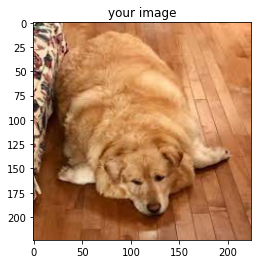

성견이군요. 입력된 견종에 따른 학습 모델을 실행하면 될 것 같습니다.


In [ ]:
from PIL import Image
image = Image.open('/home/tutor/안재형/dog_pic/test_set/dog/test_dog.jpg')
image = transforms_test(image).unsqueeze(0).to(device)

with torch.no_grad():
    outputs = model(image)
    
    _, preds = torch.max(outputs, 1)
    imshow(image.cpu().data[0], title = 'your image')
    
    if class_names[preds[0]] == 'cat' or class_names[preds[0]] == 'human':
        print(f'당신의 이미지는 {class_names[preds[0]]} 입니다! 성견 이미지를 업로드하세요')
    else:
        print('성견이군요. 입력된 견종에 따른 학습 모델을 실행하면 될 것 같습니다.')

In [ ]:
# Tensor of shape 3, with confidence scores over Imagenet's 3 classes
print(outputs[0])

# The output has unnormalized scores. To get probabilities, you can run a softmax on it.
probabilities = torch.nn.functional.softmax(outputs[0], dim=0)
print(probabilities)

tensor([-5.6447, 11.6615, -6.6801], device='cuda:0')
tensor([3.0477e-08, 1.0000e+00, 1.0823e-08], device='cuda:0')
